In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from norse.torch.module import LIFRecurrentCell
from torch.utils.tensorboard import SummaryWriter
import norse.torch as norse
from norse.torch.utils import tensorboard

In [2]:
hook = tensorboard.hook_spike_image("lif", SummaryWriter())
norse.LIFCell().register_forward_hook(hook)

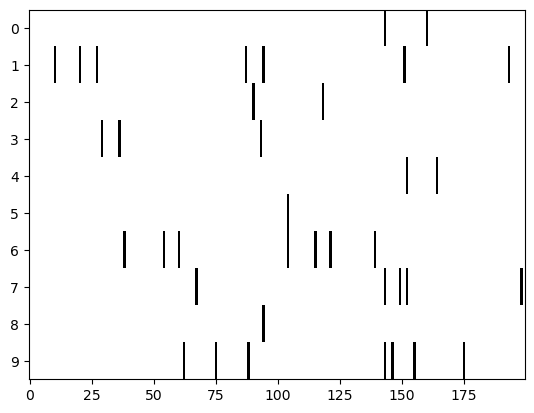

C:\Users\Brhan\AppData\Local\Temp\ipykernel_11624\3085861991.py:10: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/core/TensorImpl.h:1911.)
  data.names = ('L', 'T', 'X', 'Y')


[<Axes3DSubplot:>, <Axes3DSubplot:>, <Axes3DSubplot:>]

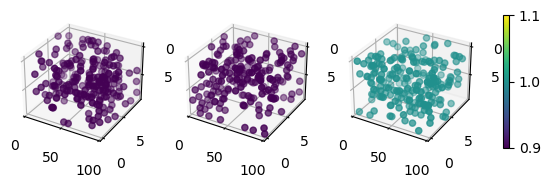

In [3]:
from norse.torch import LIF
from norse.torch.utils.plot import plot_spikes_2d
spikes, _ = LIF()(torch.randn(200, 10))
plot_spikes_2d(spikes)
plt.show()

from norse.torch.utils.plot import plot_scatter_3d
distribution = torch.distributions.bernoulli.Bernoulli(torch.tensor([0.02]))
data = distribution.sample(sample_shape=(3, 100, 10, 10)).squeeze()
data.names = ('L', 'T', 'X', 'Y')
plot_scatter_3d(data)

In [4]:
class ParametrizedLIFRecurrentCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ParametrizedLIFRecurrentCell, self).__init__()
        self.tau_mem_inv = nn.Parameter(norse.functional.lif.LIFParameters().tau_mem_inv + 20*torch.randn(hidden_size))
        self.v_th = nn.Parameter(0.5 + 0.1 * torch.randn(hidden_size))
        self.cell = norse.module.LIFRecurrentCell(input_size=input_size, hidden_size=hidden_size, 
                                                        p = norse.functional.lif.LIFParameters(
                                                            tau_mem_inv = self.tau_mem_inv,
                                                            v_th = self.v_th,
                                                            alpha = 100,
                                                        )
                                                        
        )

    def forward(self, x, s = None):
        return self.cell(x, s)

In [5]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE
)

In [6]:
from norse.torch import LICell

class SNN(torch.nn.Module):
    def __init__(self, 
                 input_features,
                 hidden_features, 
                 output_features,
                 recurrent_cell
                ):
        super(SNN, self).__init__()
        self.cell = recurrent_cell
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell()
        self.input_features = input_features
                             
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []


        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.cell(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            voltages += [vo]
        
        return torch.stack(voltages)

In [7]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [8]:
from tqdm.notebook import tqdm, trange

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        target = data ####
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [9]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = data ####
            output = model(data)
            test_loss += nn.functional.mse_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [10]:
from norse.torch import ConstantCurrentLIFEncoder

def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = nn.functional.log_softmax(x, dim=1)
    return log_p_y


T = 32
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 28*28
EPOCHS = 5

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

In [11]:
def run_training(model, optimizer, epochs = EPOCHS):
    training_losses = []
    mean_losses = []
    test_losses = []
    accuracies = []

    torch.autograd.set_detect_anomaly(True)

    for epoch in trange(epochs):
        training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
        test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
        training_losses += training_loss
        mean_losses.append(mean_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)

    print(f"final accuracy: {accuracies[-1]}")
    return model

In [12]:
model = Model(
    encoder=ConstantCurrentLIFEncoder(
      seq_length=T,
    ),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES,
      recurrent_cell=ParametrizedLIFRecurrentCell(
            input_size=28*28, 
            hidden_size=100
      )
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [13]:
tau_mem_inv_before = model.snn.cell.cell.p.tau_mem_inv.cpu().detach().numpy()
v_th_before = model.snn.cell.cell.p.v_th.cpu().detach().numpy()

In [14]:
model_after = run_training(model, optimizer, epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

TypeError: max() received an invalid combination of arguments - got (Unflatten, int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [ ]:
tau_mem_inv_after = model_after.snn.cell.cell.p.tau_mem_inv.cpu().detach().numpy()
v_th_after = model_after.snn.cell.cell.p.v_th.cpu().detach().numpy()

In [ ]:
counts, bins = np.histogram(tau_mem_inv_before)
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='before')
counts, bins = np.histogram(tau_mem_inv_after)
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='after')
ax.set_xlabel('$\\tau_{m}^{-1}$ [ms]')
ax.legend()

In [ ]:
counts, bins = np.histogram(v_th_before)
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='before')
counts, bins = np.histogram(v_th_after)
ax.hist(bins[:-1], bins, weights=counts, histtype='step', label='after')
ax.set_xlabel('$v_{th}$ [a.u.]')
ax.legend()